# Imports

In [ ]:
!pip install pydicom

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import os
from tensorflow.keras.models import load_model
import re
import cv2
import pydicom
import nibabel as nib
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
import math
tf.config.run_functions_eagerly(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Custom Metrics

In [ ]:
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels = 6):
    dice = 0
    weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,index], y_pred[:,:,index]) * weights[index]
    return dice/np.sum(weights)

def dice_coef_multilabelloss(y_true, y_pred):
    return 1 - dice_coef_multilabel(y_true, y_pred)

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):
        true = K.cast(true, K.floatx())
        pred = K.cast(pred, K.floatx())

        axis = -1 #if channels last
          #axis=  1 #if channels first


          #argmax returns the index of the element with the greatest value
          #done in the class axis, it returns the class index
        classSelectors = K.argmax(true, axis=axis)
              #if your loss is sparse, use only true as classSelectors

          #considering weights are ordered by class, for each class
          #true(1) if the class index is equal to the weight index
          #weightsList = tf.cast(weightsList, tf.int64)
        classSelectors = [K.equal(tf.cast(i, tf.int64), tf.cast(classSelectors, tf.int64)) for i in range(len(weightsList))]

          #casting boolean to float for calculations
          #each tensor in the list contains 1 where ground true class is equal to its index
          #if you sum all these, you will get a tensor full of ones.
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

          #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)]

          #sums all the selections
          #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


          #make sure your originalLossFunc only collapses the class axis
          #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred)
        loss = loss * weightMultiplier

        return loss
    return lossFunc

def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection

    iou = intersection / (union + 1e-10)
    return tf.reduce_mean(iou)

def mean_iou_loss(class_weights):
    def loss(y_true, y_pred):
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection

        iou = intersection / (union + 1e-10)

        # Apply class weights
        weighted_iou = iou * class_weights

        # Scale the loss by a factor (e.g., 100) to ensure it remains positive
        scaled_loss = 100.0 * tf.reduce_sum(weighted_iou) / tf.reduce_sum(class_weights)

        return scaled_loss

    return loss

# U-Net Implementation

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x


def build_unet_model():
    # inputs
    units = 128
    inputs = tf.keras.layers.Input(shape=(units,units,1))
   # encoder: contracting path - downsample
   # 1 - downsample
    f1, p1 = downsample_block(inputs, units/4)
   # 2 - downsample
    f2, p2 = downsample_block(p1, units/2)
   # 3 - downsample
    f3, p3 = downsample_block(p2, units*1)
   # 4 - downsample
    f4, p4 = downsample_block(p3, units*2)
   # 5 - bottleneck
    bottleneck = double_conv_block(p4, units*4)
   # decoder: expanding path - upsample
   # 6 - upsample
    u6 = upsample_block(bottleneck, f4, units*2)
   # 7 - upsample
    u7 = upsample_block(u6, f3, units*1)
   # 8 - upsample
    u8 = upsample_block(u7, f2, units/2)
   # 9 - upsample
    u9 = upsample_block(u8, f1, units/4)
   # outputs
    outputs = tf.keras.layers.Conv2D(6, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
model = load_model('/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/Unet_Fine_Tune_128_plus_CKP.h5', custom_objects={'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel})

In [ ]:
"""
class_weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]

try:
  from tensorflow.keras.models import load_model
  # model = load_model('/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_128_epochs.h5', custom_objects={'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel})
  model = load_model('/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_128_epochs_IoUonly.h5', custom_objects={'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel})
  print("Existing model loaded")
except:
  model = build_unet_model()
  print("New model loaded")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              # loss=weightedLoss(tf.keras.losses.categorical_crossentropy, class_weights),
              # metrics=[dice_coef_multilabel, tf.keras.metrics.MeanIoU(num_classes=6), "accuracy"])
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=tf.keras.metrics.MeanIoU(num_classes=6))
"""

In [ ]:
class_weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              # loss=weightedLoss(tf.keras.losses.categorical_crossentropy, class_weights),
              # metrics=[dice_coef_multilabel, tf.keras.metrics.MeanIoU(num_classes=6), "accuracy"])
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=tf.keras.metrics.MeanIoU(num_classes=6))

# Model summary

In [ ]:
#model.summary()

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

# TRAINING

### DataGenerator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, X_set: np.array, y_set: np.array, num_classes: int, batch_size: int) -> None:
        """_Initialization of data generator_

        Parameters
        ----------
        X_set : np.array
            _Set of images_
        y_set : _np.array_
            _Set of masks_
        num_classes : _int_
            _Number of classes_
        batch_size : _int_
            _Size of the batch taken from X_set and y_set_
        """
        self.x, self.y = X_set, y_set
        self.classes = num_classes
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, index):
        """_Get item method for each epoch in training
            and computes categorical values for
            segmentation maks_

        Parameters
        ----------
        index : _int_
            _Integer utilized to return the batches_

        Returns
        -------
        _np.array_
            _Returns the batch from X_set and categorical btach from y_set_
        """
        batch_x = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        train_masks_cat = to_categorical(batch_y, num_classes=self.classes)
        batch_y_categorical = train_masks_cat.reshape((batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], self.classes))

        return batch_x, batch_y_categorical

### Data

In [ ]:
with open(f'/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Data/X_y_segmentations_data_1.npy', 'rb') as f:
        X = np.load(f, allow_pickle = True)
        y = np.load(f, allow_pickle = True)

In [ ]:
X.shape

(15520, 128, 128, 1)

In [ ]:
# Generate random indices for sampling
indices = np.arange(len(X))
np.random.shuffle(indices)
num_samples = 4000
# Select the first num_samples indices
selected_indices = indices[:num_samples]

# Use the selected indices to extract samples from X and Y
X_test = X[selected_indices]
Y_test = y[selected_indices]

print(X_test.shape, Y_test.shape)

(4000, 128, 128, 1) (4000, 128, 128, 1)


In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [ ]:
data_generator = DataGenerator(X, y, 6, 64)
data_generator_test = DataGenerator(X_test, Y_test, 6, 32)

In [ ]:
x, Y = data_generator[2]

y_mask = np.argmax(Y, axis=3)

In [ ]:
Y.shape

(64, 128, 128, 6)

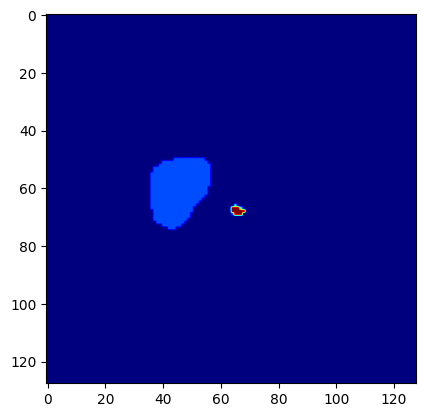

In [ ]:
plt.imshow(y_mask[60,:,:], cmap="jet")

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/Unet_Fine_Tune_128_plus_CKP.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                              monitor="val_mean_io_u",
                                                              save_best_only=True,
                                                              save_weights_only=False,
                                                              mode="max",
                                                              verbose=1)

In [ ]:
history = model.fit(data_generator,
                    validation_data=data_generator_test,
                    verbose=1,
                    epochs=128,
                    callbacks=model_checkpoint_callback,
                    shuffle=False)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/128
243/243 [==============================] - ETA: 0s - loss: 0.1396 - mean_io_u: 0.6490
Epoch 1: val_mean_io_u improved from -inf to 0.67370, saving model to /content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/Unet_Fine_Tune_128_plus_CKP.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 149s 524ms/step - loss: 0.1396 - mean_io_u: 0.6490 - val_loss: 0.1277 - val_mean_io_u: 0.6737
Epoch 2/128
243/243 [==============================] - ETA: 0s - loss: 0.1299 - mean_io_u: 0.6599
Epoch 2: val_mean_io_u improved from 0.67370 to 0.68263, saving model to /content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/Unet_Fine_Tune_128_plus_CKP.h5
243/243 [==============================] - 124s 509ms/step - loss: 0.1299 - mean_io_u: 0.6599 - val_loss: 0.1200 - val_mean_io_u: 0.6826
Epoch 3/128
243/243 [==============================] - ETA: 0s - loss: 0.1218 - mean_io_u: 0.6699
Epoch 3: val_mean_io_u improved from 0.68263 to 0.69310, saving model to /content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/Unet_Fine_Tune_128_plus_CKP.h5
243/243 [==============================] - 121s 498ms/step - loss: 0.1218 - mean_io_u: 0.6699 - val_loss: 0.1134 - val_mean_io_u: 0.6931
Epoch 4/128
243/243 [==============================] 

KeyboardInterrupt: ignored

In [ ]:
model.save(f'/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_plus_64_epochs_IoU.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

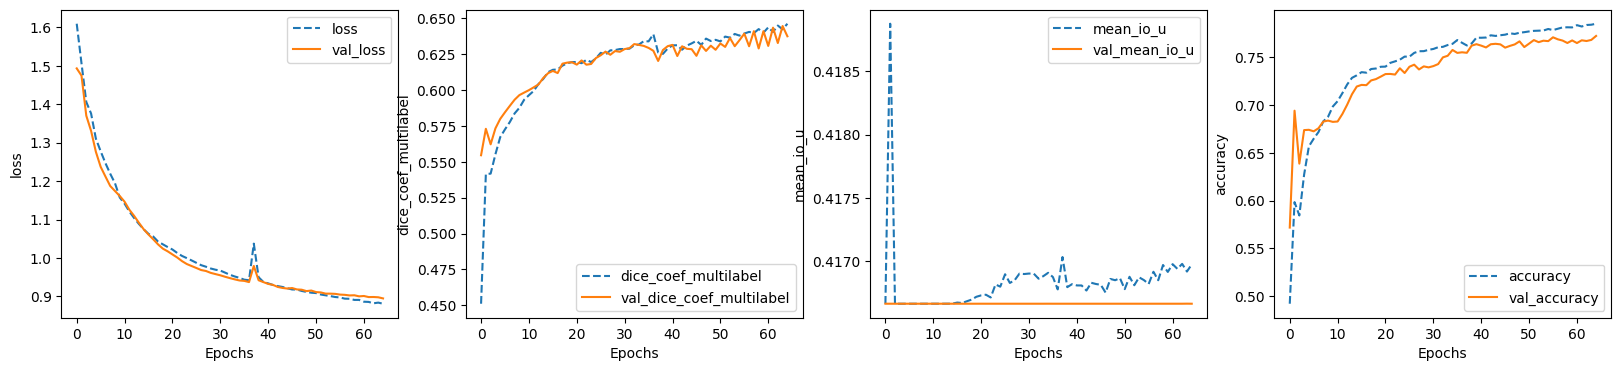

In [ ]:
training_plot(["loss", "dice_coef_multilabel", "mean_io_u", "accuracy"], history)

# Evaluation

In [ ]:
from tensorflow.keras.models import load_model

Unet = load_model('/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/UnetV_128_epochs.h5', custom_objects={'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel})

In [ ]:
class_weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]
Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=weightedLoss(tf.keras.losses.categorical_crossentropy, class_weights), metrics=[dice_coef_multilabel, tf.keras.metrics.MeanIoU(num_classes=6), "accuracy"])

In [ ]:
with open(f'/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Data/Validation_data/X_y_65504_50212_.npy', 'rb') as f:
        X_val = np.load(f, allow_pickle = True)
        y_val = np.load(f, allow_pickle = True)

In [ ]:
train_masks_cat = to_categorical(y_val, num_classes=6)
y_train_cat = train_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 6))

In [ ]:
# Evaluation on unseen data
evaluation = model.evaluate(X_val, y_train_cat)

11/11 [==============================] - 3s 286ms/step - loss: 0.1227 - mean_io_u: 0.7411


In [ ]:
y_pred = model.predict(X_val)
y_pred_argmax=np.argmax(y_pred, axis=3)

11/11 [==============================] - 1s 65ms/step


In [ ]:
y_pred_argmax.dtype

dtype('int64')

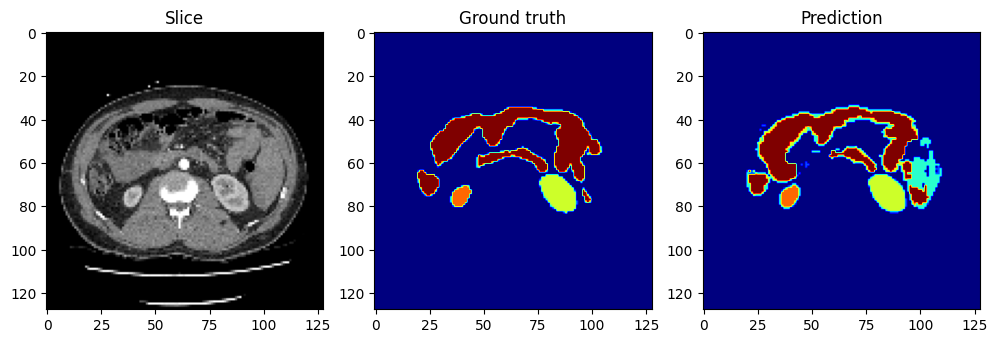

In [ ]:
index = 300

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(X_val[index,:,:], cmap='gray')
axes[0].set_title('Slice')

axes[1].imshow(y_val[index,:,:], cmap='jet')
axes[1].set_title('Ground truth')

axes[2].imshow(y_pred_argmax[index,:,:], cmap='jet')
axes[2].set_title('Prediction')

plt.tight_layout()

# Show the plot
plt.show()

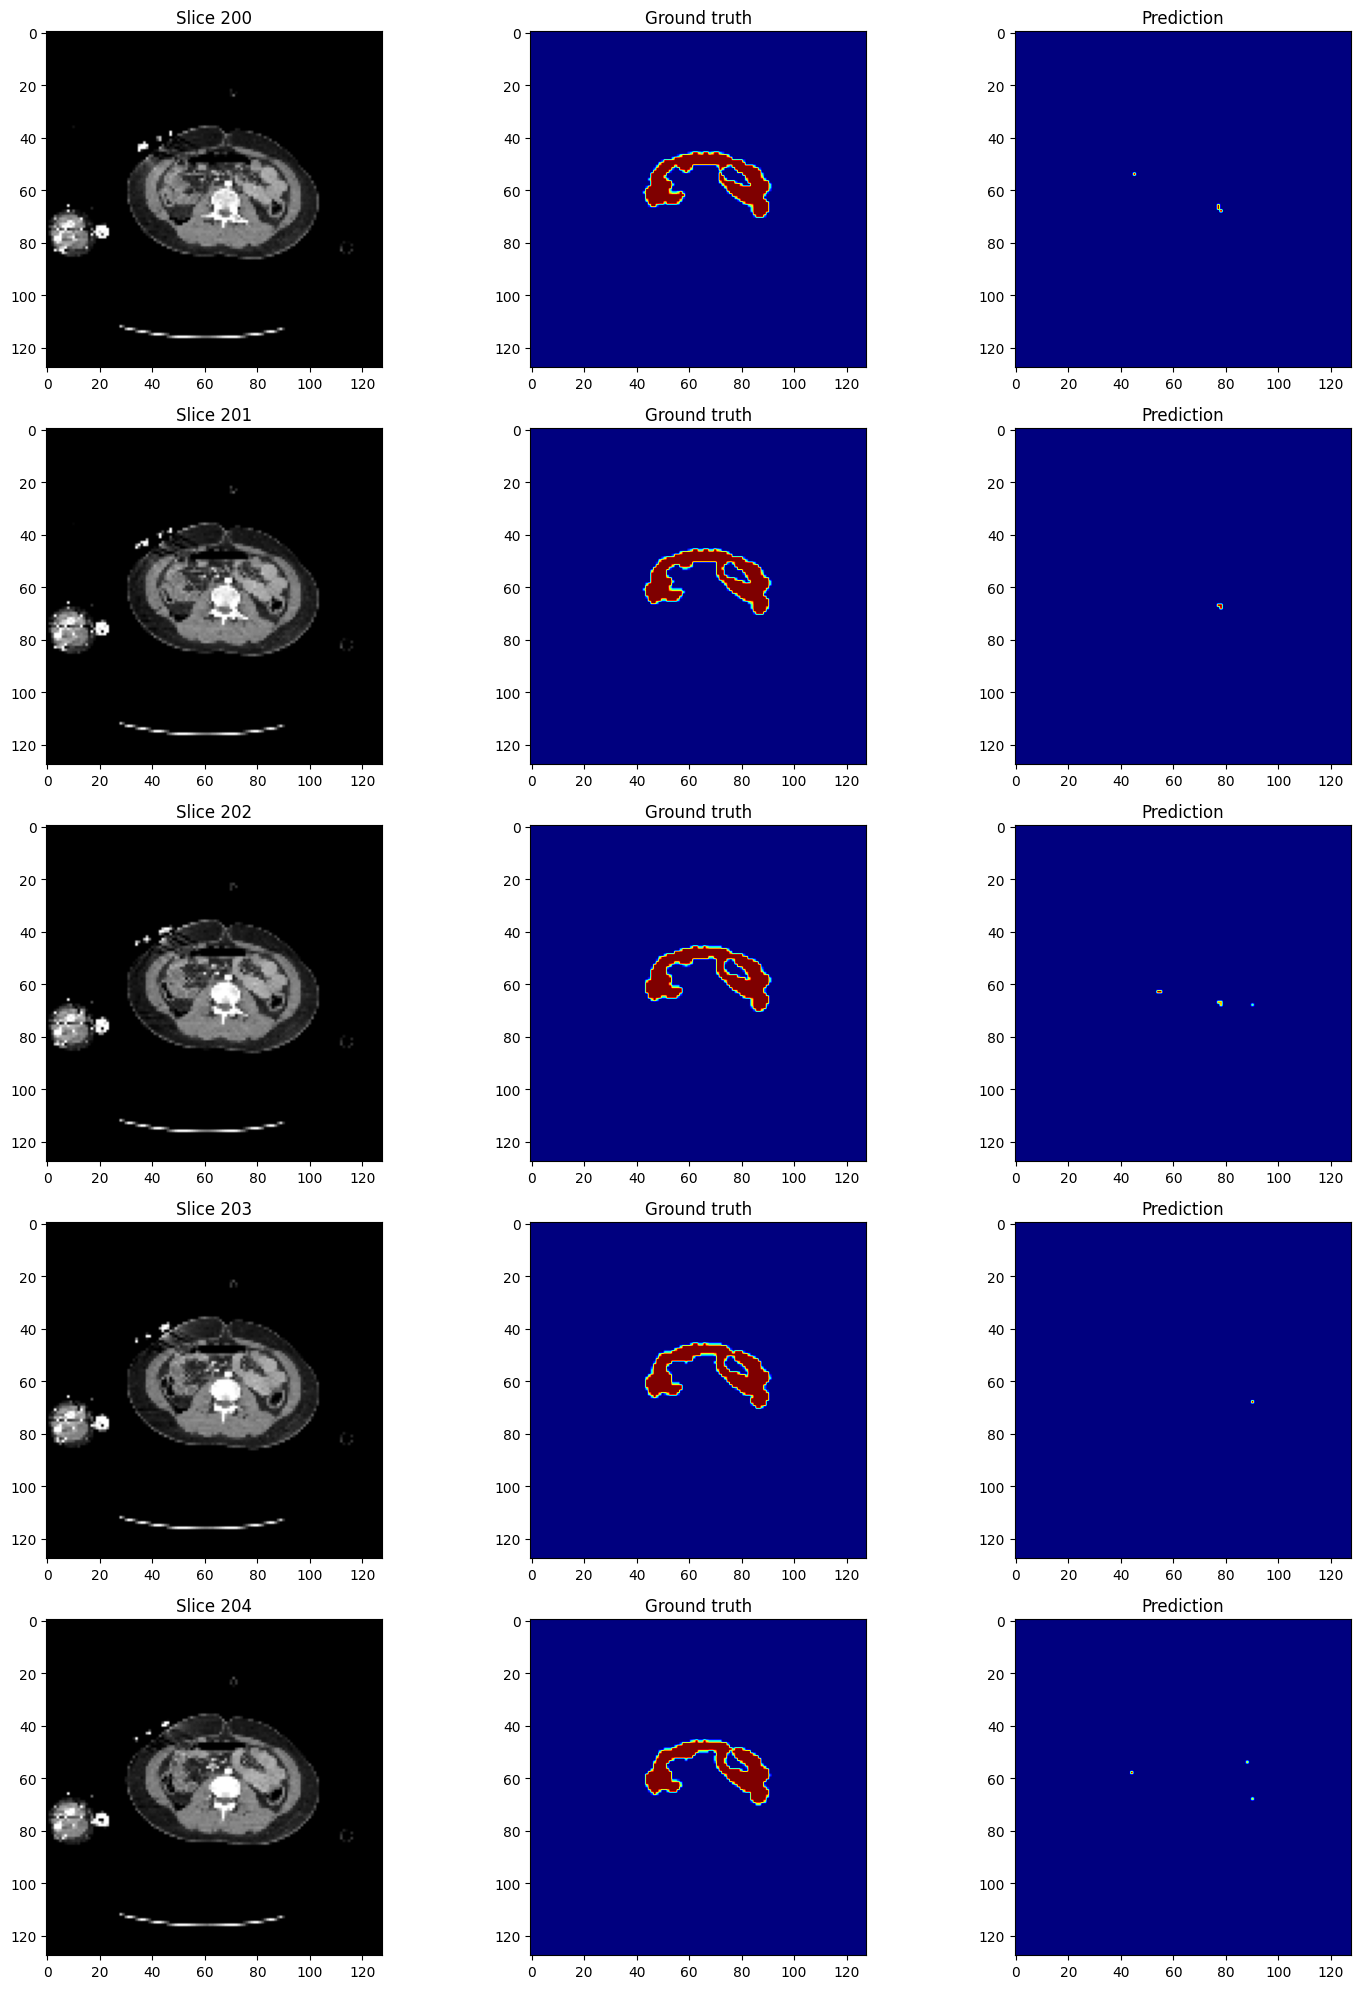

In [ ]:
num_slices = 5
index = 200
label = 1
#
# Create a figure and axes for subplots
fig, axes = plt.subplots(num_slices, 3, figsize=(15, 4 * num_slices))

# Loop through the slices and plot each one
for i in range(num_slices):

    # Define the threshold for near-maximum values
    threshold = 0.109  # Adjust this threshold as needed

    # Find the maximum value in the array
    max_value = np.max(y_pred[index + i, :, :, label])

    # Create a binary mask that selects values within the threshold range of the maximum value
    near_max_mask = np.abs(y_pred[index + i, :, :, label] - max_value) <= threshold

    # Use the binary mask to retain values within the threshold range, set others to zero
    filtered_mask = np.where(near_max_mask, y_pred_argmax[index + i, :, :], 0.0)
    axes[i, 0].imshow(X_val[index + i, :, :], cmap='gray')
    axes[i, 0].set_title(f'Slice {index + i}')

    axes[i, 1].imshow(y_val[index + i, :, :], cmap='jet')
    axes[i, 1].set_title('Ground truth')

    axes[i, 2].imshow(filtered_mask, cmap='jet')
    axes[i, 2].set_title('Prediction')

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
threshold = 0.109  # Adjust this threshold as needed
idx = 30
    # Find the maximum value in the array
max_value = np.max(y_pred[idx, :, :, label])

    # Create a binary mask that selects values within the threshold range of the maximum value
near_max_mask = np.abs(y_pred[idx, :, :, label] - max_value) <= threshold

    # Use the binary mask to retain values within the threshold range, set others to zero
filtered_mask = np.where(near_max_mask, y_pred[idx, :, :, label], 0.0)


pixel_values = filtered_mask.ravel()

np.sum(pixel_values)

11.257738